Starting 100 experiments...
Running experiment 1/100
Built graph with 42 valid nodes and 111 valid edges
Running experiment 2/100
Built graph with 41 valid nodes and 114 valid edges
Running experiment 3/100
Built graph with 48 valid nodes and 163 valid edges
Running experiment 4/100
Built graph with 51 valid nodes and 237 valid edges
Running experiment 5/100
Built graph with 38 valid nodes and 149 valid edges
Running experiment 6/100
Built graph with 46 valid nodes and 192 valid edges
Running experiment 7/100
Built graph with 32 valid nodes and 70 valid edges
Running experiment 8/100
Built graph with 44 valid nodes and 155 valid edges
Running experiment 9/100
Built graph with 58 valid nodes and 182 valid edges
Running experiment 10/100
Built graph with 37 valid nodes and 91 valid edges
Running experiment 11/100
Built graph with 44 valid nodes and 189 valid edges
Running experiment 12/100
Built graph with 37 valid nodes and 108 valid edges
Running experiment 13/100
Built graph with 46 v

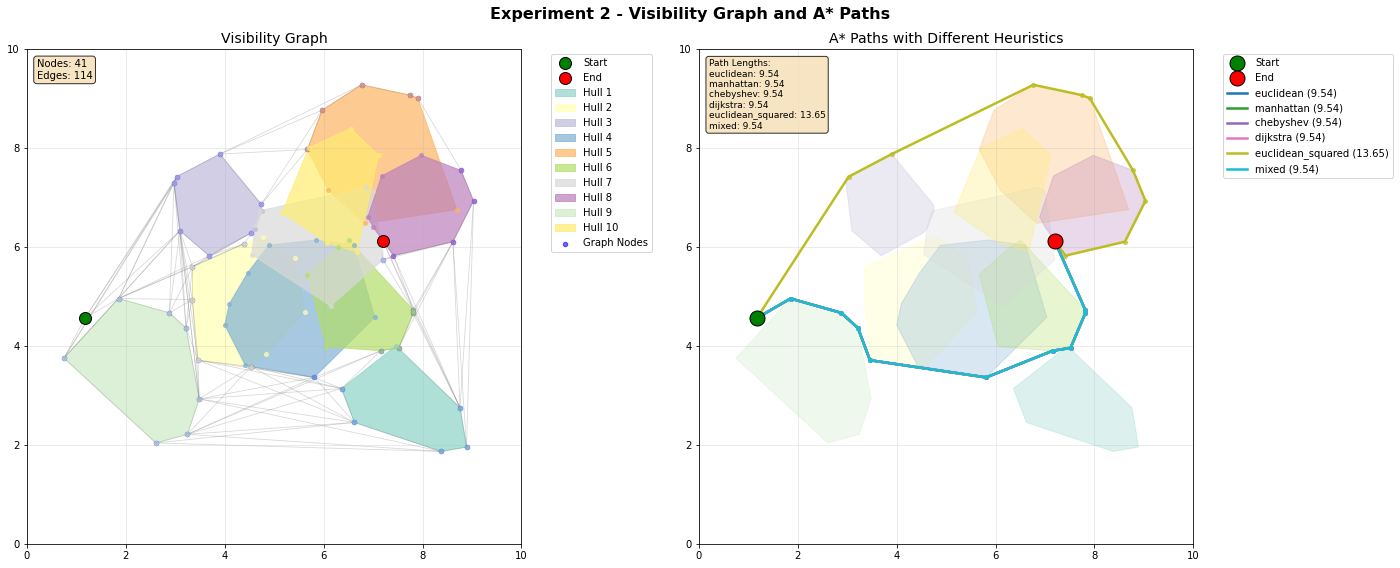

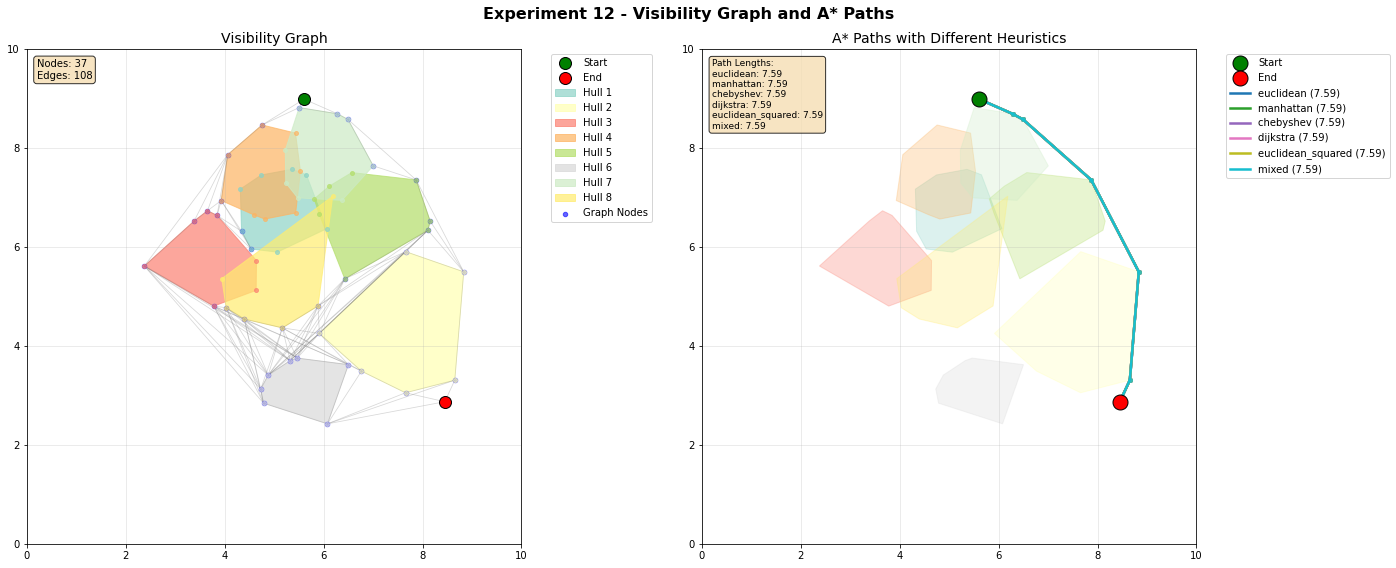

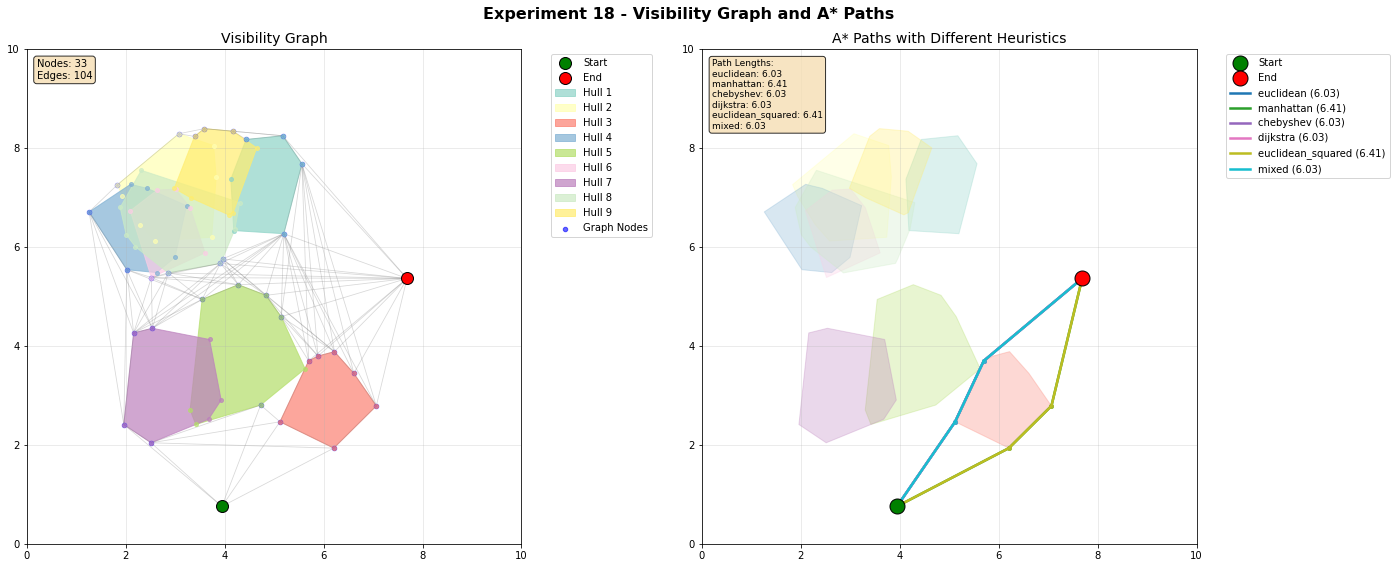

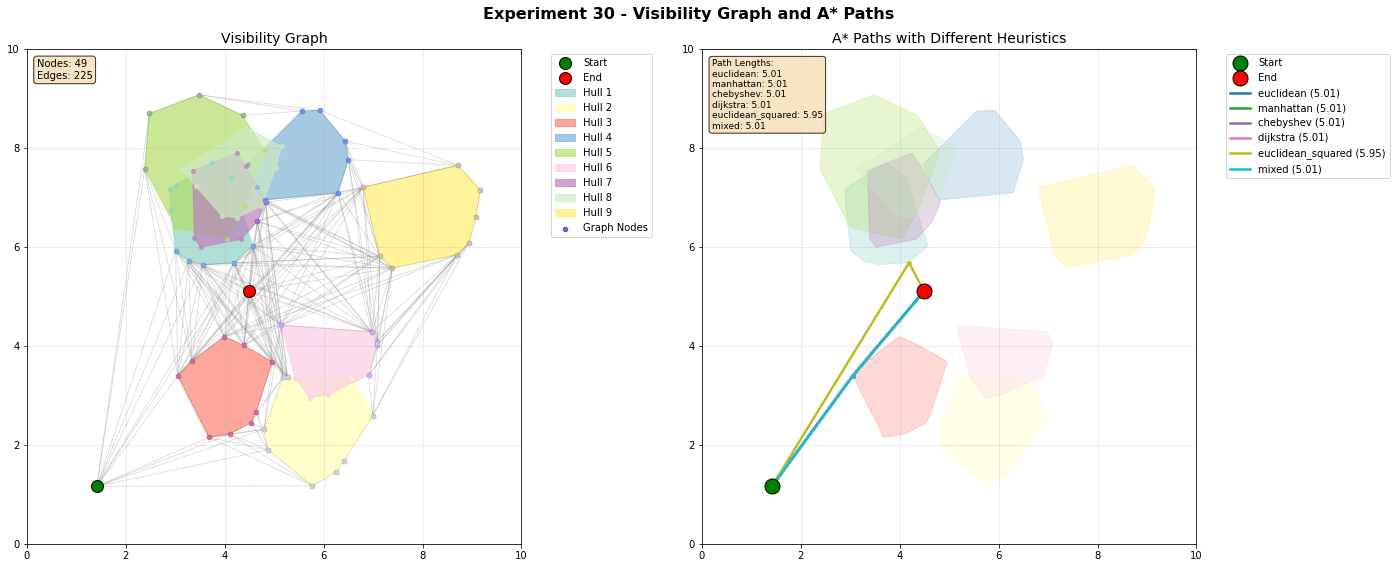

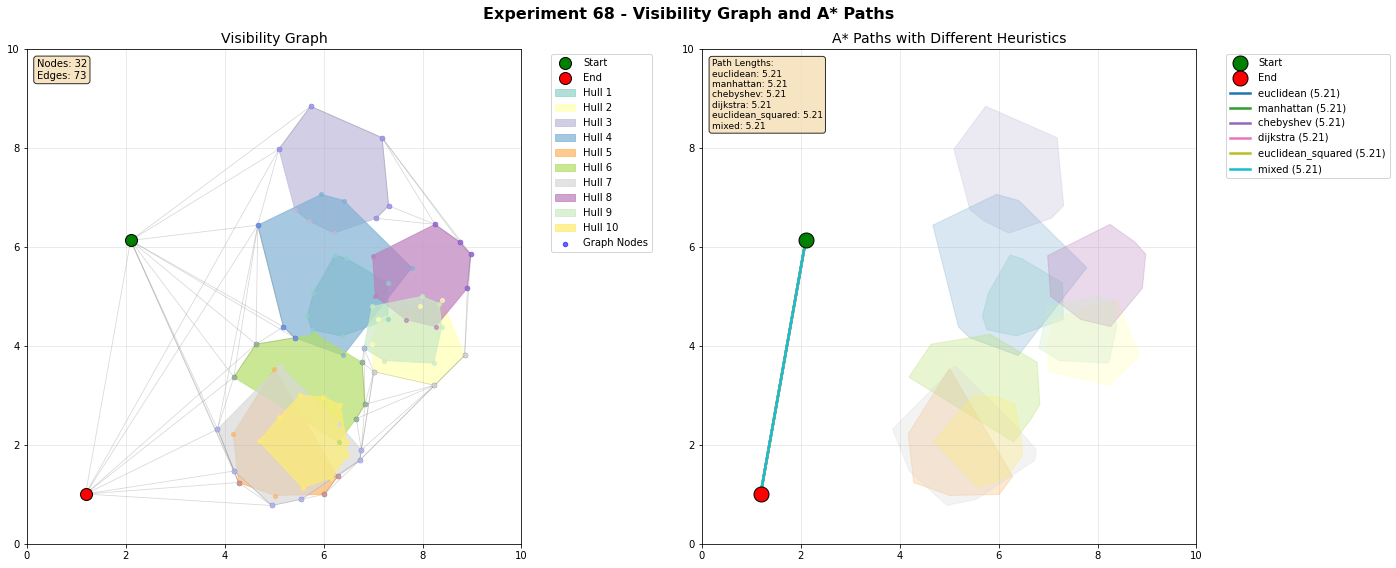

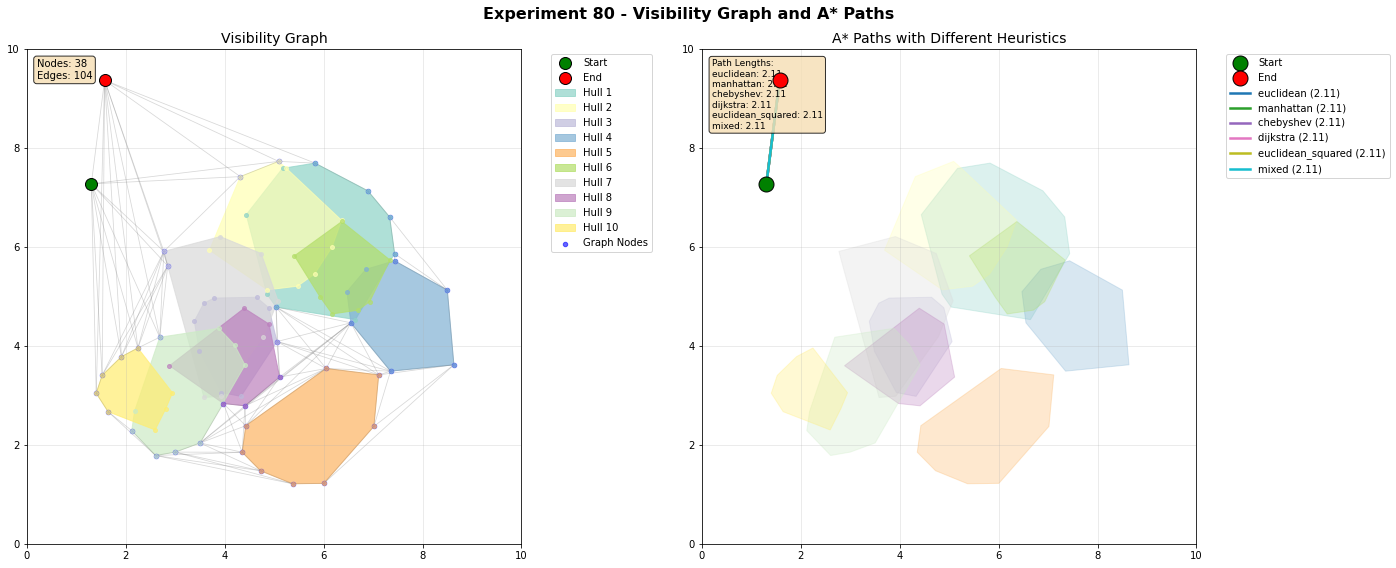

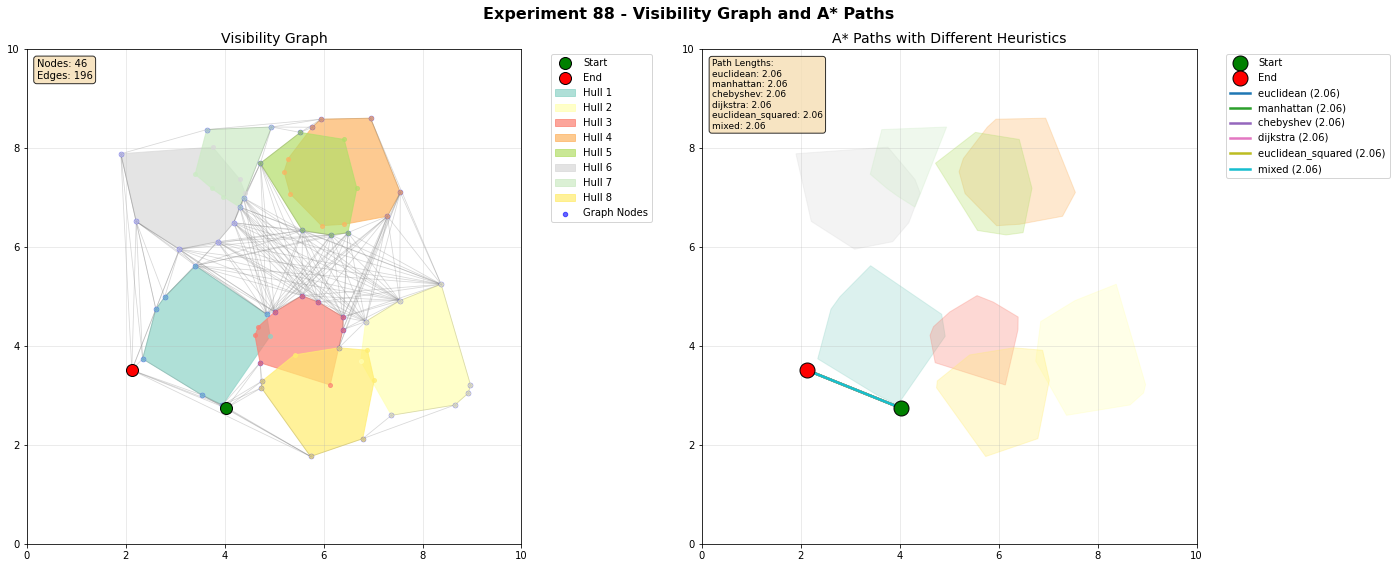

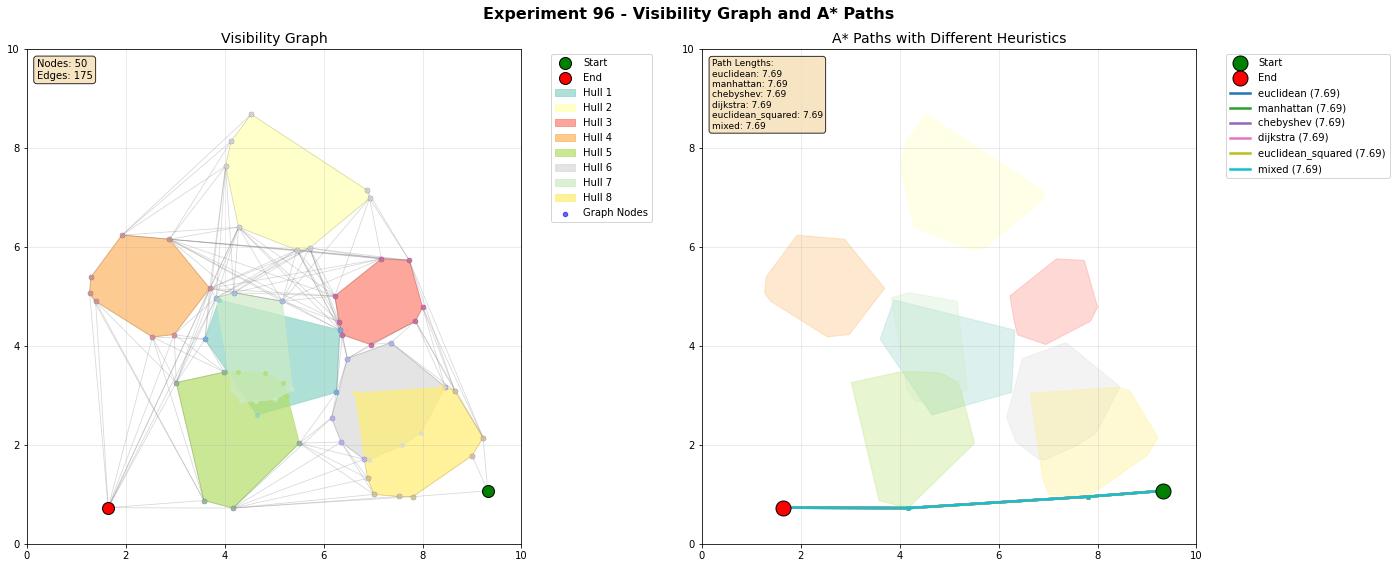

Successful experiments: 100/100

Performance Statistics:
                  path_length                          computation_time  \
                         mean     std     min      max             mean   
heuristic                                                                 
chebyshev              5.8265  2.8214  1.2826  12.2637           0.0137   
dijkstra               5.8265  2.8214  1.2826  12.2637           0.0250   
euclidean              5.8265  2.8214  1.2826  12.2637           0.0112   
euclidean_squared      6.1395  3.2233  1.2826  14.9514           0.0092   
manhattan              5.8933  2.8790  1.2826  12.3746           0.0091   
mixed                  5.8272  2.8228  1.2826  12.2637           0.0107   

                                       nodes_expanded                   \
                      std  min     max           mean      std min max   
heuristic                                                                
chebyshev          0.0107  0.0  0.0543       

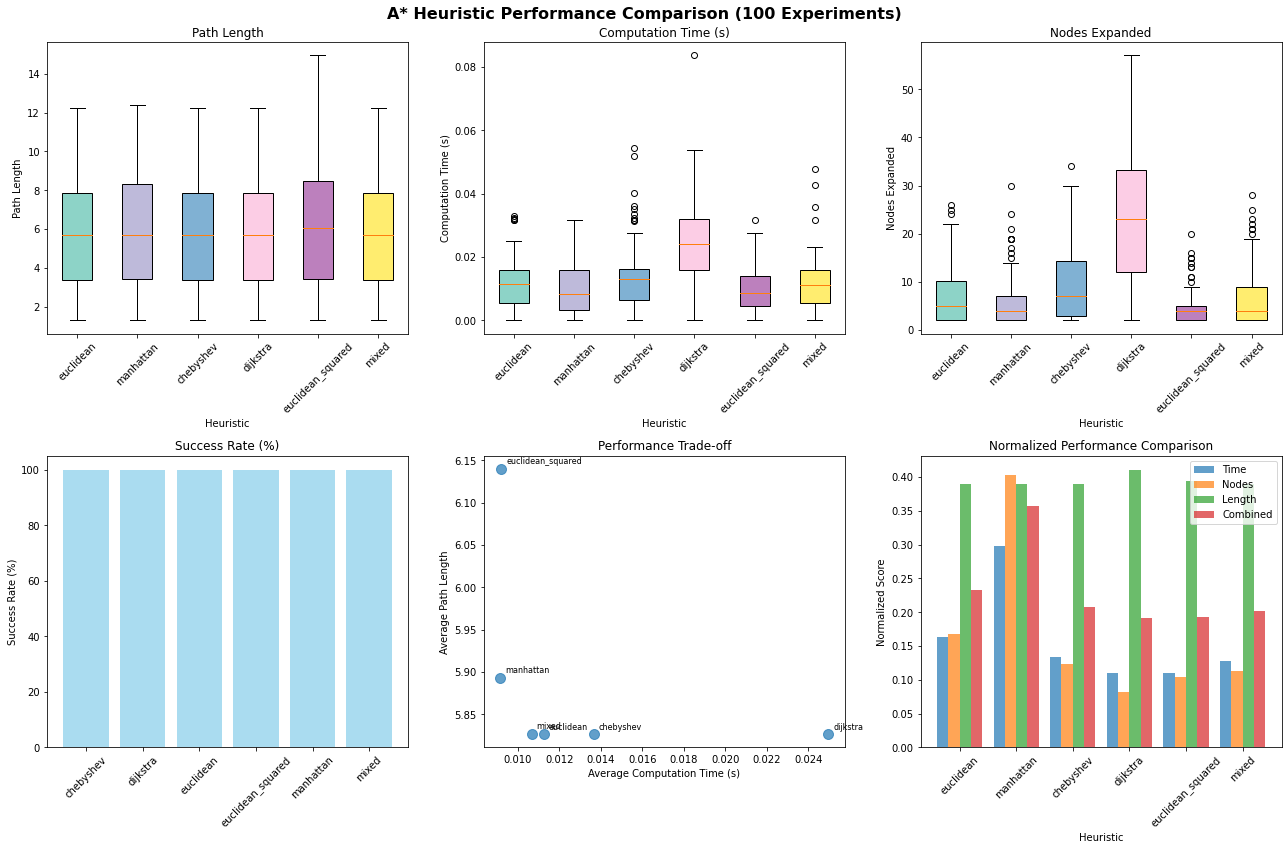

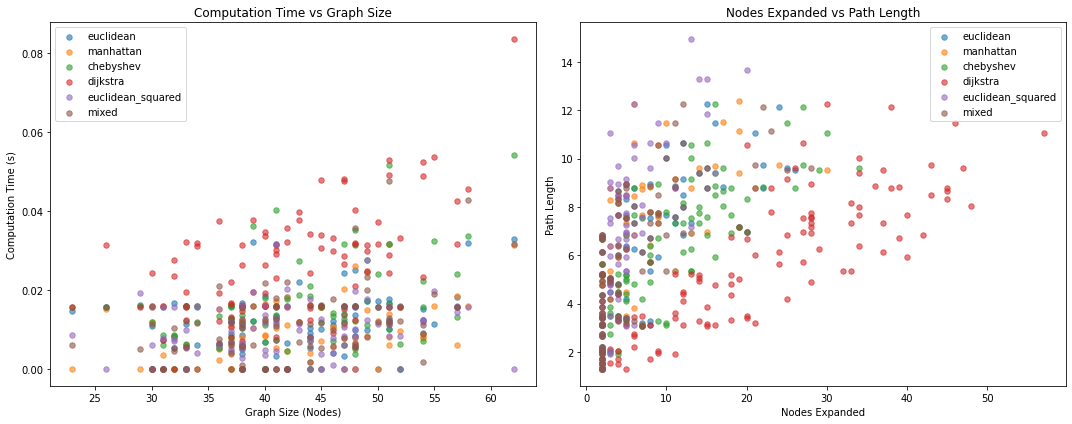


EXPERIMENT SUMMARY
Total experiments: 100
Successful experiments: 100
Heuristics tested: ['euclidean', 'manhattan', 'chebyshev', 'dijkstra', 'euclidean_squared', 'mixed']

Best heuristic for computation time: manhattan
Best heuristic for path length: chebyshev
Best heuristic for nodes expanded: euclidean_squared


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial import ConvexHull
import heapq
from matplotlib.patches import Polygon
import time
import pandas as pd
from collections import defaultdict

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __eq__(self, other):
        return abs(self.x - other.x) < 1e-10 and abs(self.y - other.y) < 1e-10
    
    def __hash__(self):
        return hash((round(self.x, 10), round(self.y, 10)))
    
    def __repr__(self):
        return f"({self.x:.2f}, {self.y:.2f})"

class Edge:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
    
    def __eq__(self, other):
        return (self.p1 == other.p1 and self.p2 == other.p2) or (self.p1 == other.p2 and self.p2 == other.p1)
    
    def __hash__(self):
        return hash((hash(self.p1) + hash(self.p2), hash(self.p2) + hash(self.p1)))

class ConvexHullGenerator:
    def __init__(self, num_hulls=8, vertices_range=(10, 12), area_range=(0.5, 2.0)):
        self.num_hulls = num_hulls
        self.vertices_range = vertices_range
        self.area_range = area_range
        self.hulls = []
    
    def generate_convex_hull(self, num_vertices):
        """Generate a random convex hull with given number of vertices"""
        # Generate points on a circle with random radius and center
        center_x = np.random.uniform(2, 8)
        center_y = np.random.uniform(2, 8)
        radius = np.random.uniform(0.8, 1.5)
        
        angles = np.sort(np.random.uniform(0, 2*np.pi, num_vertices))
        points = []
        
        for angle in angles:
            # Add some randomness to radius for irregular shapes
            r = radius * np.random.uniform(0.8, 1.2)
            x = center_x + r * np.cos(angle)
            y = center_y + r * np.sin(angle)
            points.append(Point(x, y))
        
        # Convert to numpy array for convex hull calculation
        np_points = np.array([[p.x, p.y] for p in points])
        hull = ConvexHull(np_points)
        
        # Get hull vertices in order
        hull_points = [Point(np_points[vertex, 0], np_points[vertex, 1]) for vertex in hull.vertices]
        
        return hull_points
    
    def generate_all_hulls(self):
        """Generate all convex hulls"""
        self.hulls = []
        for i in range(self.num_hulls):
            num_vertices = np.random.randint(self.vertices_range[0], self.vertices_range[1] + 1)
            hull = self.generate_convex_hull(num_vertices)
            self.hulls.append(hull)
        return self.hulls

class GeometryUtils:
    @staticmethod
    def ccw(a, b, c):
        """Check if points a, b, c are in counter-clockwise order"""
        return (b.x - a.x) * (c.y - a.y) - (b.y - a.y) * (c.x - a.x)
    
    @staticmethod
    def on_segment(a, b, c):
        """Check if point c is on segment ab"""
        return (min(a.x, b.x) <= c.x <= max(a.x, b.x) and 
                min(a.y, b.y) <= c.y <= max(a.y, b.y))
    
    @staticmethod
    def segments_intersect(edge1, edge2):
        """Check if two line segments intersect"""
        a, b = edge1.p1, edge1.p2
        c, d = edge2.p1, edge2.p2
        
        # Skip if edges share a vertex (they're connected)
        if a == c or a == d or b == c or b == d:
            return False
        
        o1 = GeometryUtils.ccw(a, b, c)
        o2 = GeometryUtils.ccw(a, b, d)
        o3 = GeometryUtils.ccw(c, d, a)
        o4 = GeometryUtils.ccw(c, d, b)
        
        # General case
        if o1 * o2 < 0 and o3 * o4 < 0:
            return True
        
        # Special cases (collinear points)
        if o1 == 0 and GeometryUtils.on_segment(a, b, c):
            return True
        if o2 == 0 and GeometryUtils.on_segment(a, b, d):
            return True
        if o3 == 0 and GeometryUtils.on_segment(c, d, a):
            return True
        if o4 == 0 and GeometryUtils.on_segment(c, d, b):
            return True
        
        return False
    
    @staticmethod
    def point_inside_polygon(point, polygon):
        """Check if a point is inside a polygon using ray casting algorithm"""
        n = len(polygon)
        inside = False
        
        p1 = polygon[0]
        for i in range(1, n + 1):
            p2 = polygon[i % n]
            if point.y > min(p1.y, p2.y):
                if point.y <= max(p1.y, p2.y):
                    if point.x <= max(p1.x, p2.x):
                        if p1.y != p2.y:
                            xinters = (point.y - p1.y) * (p2.x - p1.x) / (p2.y - p1.y) + p1.x
                        if p1.x == p2.x or point.x <= xinters:
                            inside = not inside
            p1 = p2
        
        return inside
    
    @staticmethod
    def distance(p1, p2):
        """Euclidean distance between two points"""
        return math.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)
    
    @staticmethod
    def manhattan_distance(p1, p2):
        """Manhattan distance between two points"""
        return abs(p1.x - p2.x) + abs(p1.y - p2.y)
    
    @staticmethod
    def chebyshev_distance(p1, p2):
        """Chebyshev distance between two points"""
        return max(abs(p1.x - p2.x), abs(p1.y - p2.y))

class VisibilityGraph:
    def __init__(self, hulls, start, end):
        self.hulls = hulls
        self.start = start
        self.end = end
        self.nodes = []
        self.edges = []
        self.graph = {}
        self.hull_edges = self._get_all_hull_edges()
        
    def _get_all_hull_edges(self):
        """Get all edges that form the convex hull boundaries"""
        hull_edges = []
        for hull in self.hulls:
            for i in range(len(hull)):
                edge = Edge(hull[i], hull[(i + 1) % len(hull)])
                hull_edges.append(edge)
        return hull_edges
    
    def get_all_vertices(self):
        """Get all vertices from all hulls plus start and end points"""
        all_vertices = [self.start, self.end]
        for hull in self.hulls:
            all_vertices.extend(hull)
        return list(set(all_vertices))  # Remove duplicates
    
    def is_vertex_valid(self, vertex):
        """Check if a vertex is not inside any other convex hull"""
        # Start and end points are always valid
        if vertex == self.start or vertex == self.end:
            return True
            
        # Check if this vertex is part of any hull's boundary
        for hull in self.hulls:
            if vertex in hull:
                # This vertex is on a hull boundary, now check if it's inside any other hull
                for other_hull in self.hulls:
                    if hull != other_hull:  # Don't check against its own hull
                        if GeometryUtils.point_inside_polygon(vertex, other_hull):
                            return False
                return True
        return False
    
    def is_edge_valid(self, edge):
        """Check if an edge doesn't properly intersect any hull edges and doesn't go through obstacles"""
        # Skip if edge is a hull edge (these are always valid)
        if edge in self.hull_edges:
            return True
        
        # Check if both endpoints are valid (not inside other hulls)
        if not (self.is_vertex_valid(edge.p1) and self.is_vertex_valid(edge.p2)):
            return False
        
        # Check if edge intersects any hull edge (proper intersection, not just touching)
        for hull_edge in self.hull_edges:
            if self._segments_properly_intersect(edge, hull_edge):
                return False
        
        # Check if edge goes through any obstacle
        # We sample points along the edge to check if they're inside any hull
        for t in [0.1, 0.3, 0.5, 0.7, 0.9]:
            sample_x = edge.p1.x + t * (edge.p2.x - edge.p1.x)
            sample_y = edge.p1.y + t * (edge.p2.y - edge.p1.y)
            sample_point = Point(sample_x, sample_y)
            
            for hull in self.hulls:
                if GeometryUtils.point_inside_polygon(sample_point, hull):
                    # Allow if the sample point is very close to a hull vertex (due to floating point)
                    close_to_vertex = False
                    for vertex in hull:
                        if GeometryUtils.distance(sample_point, vertex) < 1e-5:
                            close_to_vertex = True
                            break
                    if not close_to_vertex:
                        return False
        
        return True
    
    def _segments_properly_intersect(self, edge1, edge2):
        """Check if two segments properly intersect (not just touching at endpoints)"""
        a, b = edge1.p1, edge1.p2
        c, d = edge2.p1, edge2.p2
        
        # Check if they share an endpoint (this is allowed for visibility graph)
        if a == c or a == d or b == c or b == d:
            return False
        
        o1 = GeometryUtils.ccw(a, b, c)
        o2 = GeometryUtils.ccw(a, b, d)
        o3 = GeometryUtils.ccw(c, d, a)
        o4 = GeometryUtils.ccw(c, d, b)
        
        # Proper intersection
        if o1 * o2 < 0 and o3 * o4 < 0:
            return True
        
        return False
    
    def build_graph(self):
        """Build the visibility graph"""
        self.nodes = self.get_all_vertices()
        
        # Filter out nodes that are inside other convex hulls
        valid_nodes = [node for node in self.nodes if self.is_vertex_valid(node)]
        self.nodes = valid_nodes
        
        # Initialize graph
        self.graph = {node: [] for node in self.nodes}
        
        # Generate all possible edges and keep valid ones
        valid_edges_count = 0
        for i in range(len(self.nodes)):
            for j in range(i + 1, len(self.nodes)):
                edge = Edge(self.nodes[i], self.nodes[j])
                if self.is_edge_valid(edge):
                    distance = GeometryUtils.distance(self.nodes[i], self.nodes[j])
                    self.graph[self.nodes[i]].append((self.nodes[j], distance))
                    self.graph[self.nodes[j]].append((self.nodes[i], distance))
                    self.edges.append(edge)
                    valid_edges_count += 1
        
        print(f"Built graph with {len(self.nodes)} valid nodes and {valid_edges_count} valid edges")
        return self.graph

class AStar:
    def __init__(self, graph, heuristic_type="euclidean"):
        self.graph = graph
        self.heuristic_type = heuristic_type
        self.nodes_expanded = 0
    
    def heuristic(self, a, b):
        """Various heuristic functions for A*"""
        if self.heuristic_type == "euclidean":
            return GeometryUtils.distance(a, b)
        elif self.heuristic_type == "manhattan":
            return GeometryUtils.manhattan_distance(a, b)
        elif self.heuristic_type == "chebyshev":
            return GeometryUtils.chebyshev_distance(a, b)
        elif self.heuristic_type == "dijkstra":
            return 0  # Dijkstra's algorithm
        elif self.heuristic_type == "euclidean_squared":
            return (a.x - b.x)**2 + (a.y - b.y)**2  # Inadmissible but fast
        elif self.heuristic_type == "mixed":
            # Combination of Euclidean and Manhattan
            return 0.7 * GeometryUtils.distance(a, b) + 0.3 * GeometryUtils.manhattan_distance(a, b)
        else:
            return GeometryUtils.distance(a, b)
    
    def find_path(self, start, end):
        """Find shortest path using A* algorithm"""
        # Check if start and end are in graph
        if start not in self.graph or end not in self.graph:
            print(f"Start or end node not in graph. Start: {start in self.graph}, End: {end in self.graph}")
            return None
            
        open_set = []
        heapq.heappush(open_set, (0, start))
        
        came_from = {}
        g_score = {node: float('inf') for node in self.graph}
        g_score[start] = 0
        
        f_score = {node: float('inf') for node in self.graph}
        f_score[start] = self.heuristic(start, end)
        
        open_set_hash = {start}
        self.nodes_expanded = 0
        
        while open_set:
            current_f, current = heapq.heappop(open_set)
            open_set_hash.remove(current)
            self.nodes_expanded += 1
            
            if current == end:
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                path.append(start)
                path.reverse()
                
                # Verify that no node in the path is inside any convex hull
                if self._validate_path(path):
                    return path
                else:
                    print("Invalid path found - contains nodes inside obstacles")
                    return None
            
            for neighbor, distance in self.graph[current]:
                tentative_g_score = g_score[current] + distance
                
                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + self.heuristic(neighbor, end)
                    if neighbor not in open_set_hash:
                        heapq.heappush(open_set, (f_score[neighbor], neighbor))
                        open_set_hash.add(neighbor)
        
        return None  # No path found
    
    def _validate_path(self, path):
        """Validate that no node in the path is inside any convex hull"""
        # This is a safety check - the graph should already ensure this
        for point in path:
            # We can't check against all hulls directly here without access to hulls
            # But the graph construction should have already filtered invalid nodes
            pass
        return True

class ExperimentRunner:
    def __init__(self, num_experiments=100):
        self.num_experiments = num_experiments
        self.results = []
        self.heuristics = [
            "euclidean", 
            "manhattan", 
            "chebyshev", 
            "dijkstra", 
            "euclidean_squared",
            "mixed"
        ]
        self.visualization_experiments = []  # Store experiments for visualization
    
    def run_single_experiment(self, experiment_id):
        """Run a single experiment with all heuristics"""
        print(f"Running experiment {experiment_id + 1}/{self.num_experiments}")
        
        # Generate random scenario
        num_hulls = np.random.randint(8, 11)
        hull_generator = ConvexHullGenerator(num_hulls=num_hulls, vertices_range=(10, 12))
        hulls = hull_generator.generate_all_hulls()
        
        # Generate start and end points
        planner = PathPlanner()
        planner.hulls = hulls
        planner.generate_start_end_points()
        
        # Build visibility graph
        visibility_graph = VisibilityGraph(hulls, planner.start, planner.end)
        graph = visibility_graph.build_graph()
        
        # Store experiment data for potential visualization
        if len(self.visualization_experiments) < 8 and np.random.random() < 0.1:  # Randomly select 8 experiments
            self.visualization_experiments.append({
                'experiment_id': experiment_id,
                'hulls': hulls,
                'start': planner.start,
                'end': planner.end,
                'visibility_graph': visibility_graph,
                'graph': graph
            })
        
        experiment_results = []
        
        for heuristic in self.heuristics:
            start_time = time.time()
            astar = AStar(graph, heuristic_type=heuristic)
            path = astar.find_path(planner.start, planner.end)
            end_time = time.time()
            
            if path:
                path_length = sum(GeometryUtils.distance(path[i], path[i+1]) 
                                for i in range(len(path)-1))
                computation_time = end_time - start_time
                nodes_expanded = astar.nodes_expanded
                
                result = {
                    'experiment_id': experiment_id,
                    'heuristic': heuristic,
                    'path_length': path_length,
                    'computation_time': computation_time,
                    'nodes_expanded': nodes_expanded,
                    'path_found': True,
                    'graph_size': len(graph),
                    'graph_edges': len(visibility_graph.edges)
                }
            else:
                result = {
                    'experiment_id': experiment_id,
                    'heuristic': heuristic,
                    'path_length': float('inf'),
                    'computation_time': end_time - start_time,
                    'nodes_expanded': astar.nodes_expanded,
                    'path_found': False,
                    'graph_size': len(graph),
                    'graph_edges': len(visibility_graph.edges)
                }
            
            experiment_results.append(result)
        
        return experiment_results
    
    def run_all_experiments(self):
        """Run all experiments"""
        print(f"Starting {self.num_experiments} experiments...")
        
        for i in range(self.num_experiments):
            try:
                experiment_results = self.run_single_experiment(i)
                self.results.extend(experiment_results)
            except Exception as e:
                print(f"Experiment {i} failed: {e}")
                continue
        
        print("All experiments completed!")
        return self.results
    
    def visualize_selected_experiments(self):
        """Visualize visibility graphs for selected experiments"""
        if not self.visualization_experiments:
            print("No experiments selected for visualization")
            return
        
        print(f"Visualizing {len(self.visualization_experiments)} selected experiments...")
        
        for i, exp_data in enumerate(self.visualization_experiments[:8]):  # Show max 8 experiments
            self._visualize_single_experiment(exp_data, i)
    
    def _visualize_single_experiment(self, exp_data, vis_index):
        """Visualize a single experiment with visibility graph and paths"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        fig.suptitle(f'Experiment {exp_data["experiment_id"] + 1} - Visibility Graph and A* Paths', 
                    fontsize=16, fontweight='bold')
        
        hulls = exp_data['hulls']
        start = exp_data['start']
        end = exp_data['end']
        visibility_graph = exp_data['visibility_graph']
        graph = exp_data['graph']
        
        # Plot 1: Visibility Graph
        self._plot_visibility_graph(ax1, hulls, start, end, visibility_graph)
        ax1.set_title('Visibility Graph', fontsize=14)
        
        # Plot 2: A* Paths with Different Heuristics
        self._plot_heuristic_paths(ax2, hulls, start, end, visibility_graph, graph)
        ax2.set_title('A* Paths with Different Heuristics', fontsize=14)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_visibility_graph(self, ax, hulls, start, end, visibility_graph):
        """Plot the visibility graph"""
        # Plot convex hulls
        colors = plt.cm.Set3(np.linspace(0, 1, len(hulls)))
        for i, hull in enumerate(hulls):
            polygon = Polygon([(p.x, p.y) for p in hull], alpha=0.7, 
                            color=colors[i], label=f'Hull {i+1}')
            ax.add_patch(polygon)
            
            # Plot hull vertices
            hull_x = [p.x for p in hull]
            hull_y = [p.y for p in hull]
            ax.plot(hull_x, hull_y, 'o', color=colors[i], markersize=4, alpha=0.7)
        
        # Plot visibility graph edges
        for edge in visibility_graph.edges:
            ax.plot([edge.p1.x, edge.p2.x], [edge.p1.y, edge.p2.y], 
                   'gray', alpha=0.3, linewidth=0.8, zorder=1)
        
        # Plot start and end points
        ax.plot(start.x, start.y, 'go', markersize=12, label='Start', 
               markeredgecolor='black', linewidth=2, zorder=3)
        ax.plot(end.x, end.y, 'ro', markersize=12, label='End', 
               markeredgecolor='black', linewidth=2, zorder=3)
        
        # Plot all graph nodes
        all_nodes = visibility_graph.nodes
        node_x = [node.x for node in all_nodes]
        node_y = [node.y for node in all_nodes]
        ax.scatter(node_x, node_y, c='blue', s=20, alpha=0.6, label='Graph Nodes', zorder=2)
        
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Add statistics
        stats_text = f'Nodes: {len(all_nodes)}\nEdges: {len(visibility_graph.edges)}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    def _plot_heuristic_paths(self, ax, hulls, start, end, visibility_graph, graph):
        """Plot paths found by different heuristics"""
        # Plot convex hulls
        colors = plt.cm.Set3(np.linspace(0, 1, len(hulls)))
        for i, hull in enumerate(hulls):
            polygon = Polygon([(p.x, p.y) for p in hull], alpha=0.3, 
                            color=colors[i])
            ax.add_patch(polygon)
        
        # Plot start and end points
        ax.plot(start.x, start.y, 'go', markersize=15, label='Start', 
               markeredgecolor='black', linewidth=2, zorder=4)
        ax.plot(end.x, end.y, 'ro', markersize=15, label='End', 
               markeredgecolor='black', linewidth=2, zorder=4)
        
        # Plot paths for each heuristic
        path_colors = plt.cm.tab10(np.linspace(0, 1, len(self.heuristics)))
        heuristic_paths = []
        
        for i, heuristic in enumerate(self.heuristics):
            astar = AStar(graph, heuristic_type=heuristic)
            path = astar.find_path(start, end)
            
            if path:
                path_x = [p.x for p in path]
                path_y = [p.y for p in path]
                path_length = sum(GeometryUtils.distance(path[i], path[i+1]) 
                                for i in range(len(path)-1))
                
                ax.plot(path_x, path_y, '-', linewidth=2.5, color=path_colors[i], 
                       label=f'{heuristic} ({path_length:.2f})', zorder=3)
                ax.plot(path_x, path_y, 'o', markersize=4, color=path_colors[i], alpha=0.7, zorder=3)
                
                heuristic_paths.append((heuristic, path_length, astar.nodes_expanded))
        
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Add path statistics
        if heuristic_paths:
            stats_text = "Path Lengths:\n" + "\n".join([f"{h}: {l:.2f}" for h, l, _ in heuristic_paths])
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=9)
    
    def analyze_results(self):
        """Analyze and visualize the results"""
        df = pd.DataFrame(self.results)
        
        # Filter out experiments where no path was found for any heuristic
        successful_experiments = df.groupby('experiment_id')['path_found'].any()
        valid_experiment_ids = successful_experiments[successful_experiments].index
        df_valid = df[df['experiment_id'].isin(valid_experiment_ids)]
        
        print(f"Successful experiments: {len(valid_experiment_ids)}/{self.num_experiments}")
        
        # Calculate statistics
        stats = df_valid.groupby('heuristic').agg({
            'path_length': ['mean', 'std', 'min', 'max'],
            'computation_time': ['mean', 'std', 'min', 'max'],
            'nodes_expanded': ['mean', 'std', 'min', 'max'],
            'path_found': 'mean'
        }).round(4)
        
        print("\nPerformance Statistics:")
        print(stats)
        
        # Create visualizations
        self.create_visualizations(df_valid)
        
        return df_valid, stats
    
    def create_visualizations(self, df):
        """Create comprehensive visualization plots"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('A* Heuristic Performance Comparison (100 Experiments)', fontsize=16, fontweight='bold')
        
        # 1. Path Length Comparison
        self._plot_boxplot(axes[0, 0], df, 'path_length', 'Path Length', 'Heuristic', 'Path Length')
        
        # 2. Computation Time Comparison
        self._plot_boxplot(axes[0, 1], df, 'computation_time', 'Computation Time (s)', 'Heuristic', 'Computation Time (s)')
        
        # 3. Nodes Expanded Comparison
        self._plot_boxplot(axes[0, 2], df, 'nodes_expanded', 'Nodes Expanded', 'Heuristic', 'Nodes Expanded')
        
        # 4. Success Rate
        success_rates = df.groupby('heuristic')['path_found'].mean()
        axes[1, 0].bar(success_rates.index, success_rates.values * 100, color='skyblue', alpha=0.7)
        axes[1, 0].set_title('Success Rate (%)')
        axes[1, 0].set_ylabel('Success Rate (%)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # 5. Performance Trade-off (Time vs Path Length)
        avg_performance = df.groupby('heuristic').agg({
            'computation_time': 'mean',
            'path_length': 'mean'
        })
        scatter = axes[1, 1].scatter(avg_performance['computation_time'], 
                                   avg_performance['path_length'], 
                                   s=100, alpha=0.7)
        axes[1, 1].set_xlabel('Average Computation Time (s)')
        axes[1, 1].set_ylabel('Average Path Length')
        axes[1, 1].set_title('Performance Trade-off')
        
        # Add labels to points
        for i, heuristic in enumerate(avg_performance.index):
            axes[1, 1].annotate(heuristic, 
                              (avg_performance['computation_time'].iloc[i], 
                               avg_performance['path_length'].iloc[i]),
                              xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        # 6. Normalized Performance Comparison
        normalized_df = self._normalize_metrics(df)
        self._plot_normalized_comparison(axes[1, 2], normalized_df)
        
        plt.tight_layout()
        plt.show()
        
        # Additional detailed analysis
        self._create_detailed_analysis(df)
    
    def _plot_boxplot(self, ax, df, metric, title, xlabel, ylabel):
        """Helper function to create box plots"""
        data = [df[df['heuristic'] == h][metric].values for h in self.heuristics]
        box_plot = ax.boxplot(data, labels=self.heuristics, patch_artist=True)
        
        # Color the boxes
        colors = plt.cm.Set3(np.linspace(0, 1, len(self.heuristics)))
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)
        
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.tick_params(axis='x', rotation=45)
    
    def _normalize_metrics(self, df):
        """Normalize metrics for comparison"""
        normalized_data = []
        
        for heuristic in self.heuristics:
            heuristic_data = df[df['heuristic'] == heuristic]
            
            # Normalize each metric (lower is better)
            norm_time = heuristic_data['computation_time'] / df['computation_time'].max()
            norm_nodes = heuristic_data['nodes_expanded'] / df['nodes_expanded'].max()
            norm_length = heuristic_data['path_length'] / df['path_length'].max()
            
            # Combined score (weighted average)
            combined_score = 0.4 * norm_time + 0.3 * norm_nodes + 0.3 * norm_length
            
            for i in range(len(heuristic_data)):
                normalized_data.append({
                    'heuristic': heuristic,
                    'norm_time': norm_time.iloc[i],
                    'norm_nodes': norm_nodes.iloc[i],
                    'norm_length': norm_length.iloc[i],
                    'combined_score': combined_score.iloc[i]
                })
        
        return pd.DataFrame(normalized_data)
    
    def _plot_normalized_comparison(self, ax, normalized_df):
        """Plot normalized performance comparison"""
        avg_scores = normalized_df.groupby('heuristic').agg({
            'norm_time': 'mean',
            'norm_nodes': 'mean', 
            'norm_length': 'mean',
            'combined_score': 'mean'
        })
        
        x = np.arange(len(self.heuristics))
        width = 0.2
        
        ax.bar(x - 1.5*width, avg_scores['norm_time'], width, label='Time', alpha=0.7)
        ax.bar(x - 0.5*width, avg_scores['norm_nodes'], width, label='Nodes', alpha=0.7)
        ax.bar(x + 0.5*width, avg_scores['norm_length'], width, label='Length', alpha=0.7)
        ax.bar(x + 1.5*width, avg_scores['combined_score'], width, label='Combined', alpha=0.7)
        
        ax.set_xlabel('Heuristic')
        ax.set_ylabel('Normalized Score')
        ax.set_title('Normalized Performance Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(self.heuristics, rotation=45)
        ax.legend()
    
    def _create_detailed_analysis(self, df):
        """Create additional detailed analysis plots"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Performance by graph size
        for heuristic in self.heuristics:
            heuristic_data = df[df['heuristic'] == heuristic]
            axes[0].scatter(heuristic_data['graph_size'], heuristic_data['computation_time'], 
                          alpha=0.6, label=heuristic, s=30)
        
        axes[0].set_xlabel('Graph Size (Nodes)')
        axes[0].set_ylabel('Computation Time (s)')
        axes[0].set_title('Computation Time vs Graph Size')
        axes[0].legend()
        
        # Nodes expanded vs path length correlation
        for heuristic in self.heuristics:
            heuristic_data = df[df['heuristic'] == heuristic]
            axes[1].scatter(heuristic_data['nodes_expanded'], heuristic_data['path_length'], 
                          alpha=0.6, label=heuristic, s=30)
        
        axes[1].set_xlabel('Nodes Expanded')
        axes[1].set_ylabel('Path Length')
        axes[1].set_title('Nodes Expanded vs Path Length')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()

class PathPlanner:
    def __init__(self):
        self.hulls = []
        self.start = None
        self.end = None
    
    def generate_start_end_points(self, x_range=(0, 10), y_range=(0, 10)):
        """Generate start and end points that are not inside any hull"""
        max_attempts = 100
        attempts = 0
        
        while attempts < max_attempts:
            start = Point(np.random.uniform(x_range[0] + 0.5, x_range[1] - 0.5), 
                         np.random.uniform(y_range[0] + 0.5, y_range[1] - 0.5))
            end = Point(np.random.uniform(x_range[0] + 0.5, x_range[1] - 0.5), 
                       np.random.uniform(y_range[0] + 0.5, y_range[1] - 0.5))
            
            valid_start = True
            valid_end = True
            
            for hull in self.hulls:
                if GeometryUtils.point_inside_polygon(start, hull):
                    valid_start = False
                if GeometryUtils.point_inside_polygon(end, hull):
                    valid_end = False
            
            if valid_start and valid_end and start != end:
                self.start = start
                self.end = end
                return
            
            attempts += 1
        
        # If we can't find valid points after max attempts, use fallback
        self.start = Point(0.5, 0.5)
        self.end = Point(9.5, 9.5)

# Run experiments
if __name__ == "__main__":
    # Run the experiments
    experiment_runner = ExperimentRunner(num_experiments=100)
    results = experiment_runner.run_all_experiments()
    
    # Visualize selected experiments with visibility graphs
    experiment_runner.visualize_selected_experiments()
    
    # Analyze and plot results
    df, stats = experiment_runner.analyze_results()
    
    # Print summary
    print("\n" + "="*60)
    print("EXPERIMENT SUMMARY")
    print("="*60)
    print(f"Total experiments: {experiment_runner.num_experiments}")
    print(f"Successful experiments: {len(df['experiment_id'].unique())}")
    print(f"Heuristics tested: {experiment_runner.heuristics}")
    
    # Best performing heuristic for each metric
    best_time = stats[('computation_time', 'mean')].idxmin()
    best_length = stats[('path_length', 'mean')].idxmin()
    best_nodes = stats[('nodes_expanded', 'mean')].idxmin()
    
    print(f"\nBest heuristic for computation time: {best_time}")
    print(f"Best heuristic for path length: {best_length}")
    print(f"Best heuristic for nodes expanded: {best_nodes}")